<a href="https://colab.research.google.com/github/Kevcamposs/Python-for-hidrometeorology/blob/main/6_Markov_2th.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Feedback, consultas o chismes:
* kevin.camposs1926@gmail.com
* 20180167@lamolina.edu.pe

In [ ]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd, seaborn as sns
%matplotlib inline

df = pd.DataFrame(pd.read_csv('/content/pp_m.csv'))
df.columns = ['pp']; df.index = pd.date_range(start = '01/01/1981', end = '12/31/2016', freq = 'm') # columns - index
df_pred = df.loc['01/2011':'12/2011'] # 2010-2011 predicción
df = df.loc['01/1981':'12/2010'] # 1981-2010

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


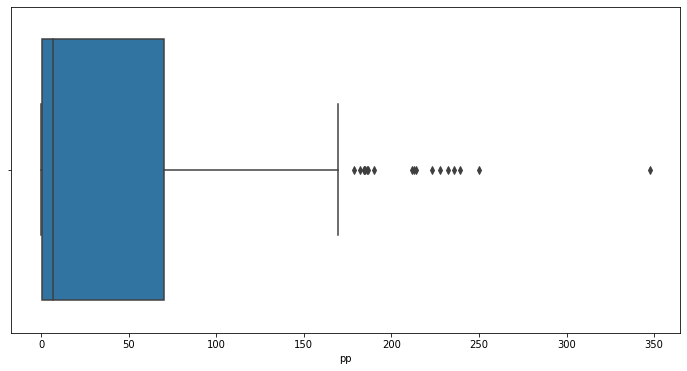

In [ ]:
p10 = np.percentile(a = df['pp'].values, q = 10) # mes muy seco
pQ1 = np.percentile(a = df['pp'].values, q = 25) # mes seco
pQ3 = np.percentile(a = df['pp'].values, q = 75) # mes húmedo
p90 = np.percentile(a = df['pp'].values, q = 90) # mes muy húmedo

plt.figure(figsize=(12,6))
sns.boxplot(df['pp'])

In [ ]:
#### CLASIFICACIÓN
class_col = np.arange(len(df)); class_str = pd.Series(range(len(df)))
for i in range(len(df)):
  if df['pp'][i] <= p10: j = 0; k = 'D'        # Muy seco
  elif p10< df['pp'][i] <=pQ1: j = 1; k = 'd'  # Seco
  elif pQ1< df['pp'][i] <=pQ3: j = 2; k = 'n'  # Normal
  elif pQ3< df['pp'][i] <=p90: j = 3; k = 'w'  # Húmedo
  elif p90< df['pp'][i]: j = 4; k = 'W'        # Muy húmedo

  class_col[i], class_str[i] = j, k
  df['class'] = class_col; df['class_str'] = class_str.values

pp_D = df[df['pp'] <= p10]['pp'].values.mean()
pp_d = df[p10< df['pp']][df['pp'] <=pQ1]['pp'].values.mean()
pp_n = df[pQ1< df['pp']][df['pp'] <=pQ3]['pp'].values.mean()
pp_w = df[pQ3< df['pp']][df['pp'] <=p90]['pp'].values.mean()
pp_W = df[p90< df['pp']]['pp'].values.mean()

pp_class = [pp_D, pp_d, pp_n, pp_w, pp_W]
pp_dic = {'D':pp_D, 'd':pp_d, 'n':pp_n, 'w':pp_w, 'W':pp_W}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


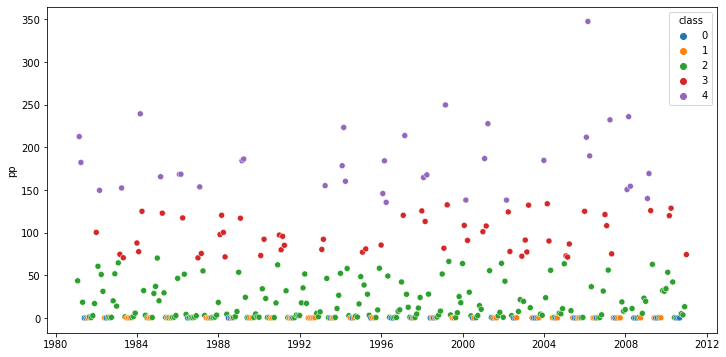

In [ ]:
plt.figure(figsize=(12,6))
sns.scatterplot(x = df.index, y = df['pp'], hue = df['class'], palette="tab10", )

In [ ]:
# Markov 2do orden: estados
c_1 = pd.DataFrame.copy(df['class_str'])
c_1_a = c_1.resample('2M').sum(); c_1_b = c_1[1:].resample('2M').sum(); c_1_b[0] = c_1_a[0] + c_1_b[0]
c_1 = pd.concat([c_1_a, c_1_b]).sort_index()[:-1]; c_1[0] = np.NaN

states = set(filter(lambda x: x == x , c_1))# Posibles estados. Nota: aprovechar que NaN != NaN para eliminarlo

# Probabilidades condicionales: https://www.py4u.net/discuss/147026
cc_1 = pd.DataFrame(np.transpose([(c_1), c_1.shift(-1)]), columns=['c','c+1'])
cc_1_copy = pd.DataFrame.copy(cc_1)

c_probs = cc_1.groupby('c').size().div(len(cc_1)-1) # se le resta 2 porque se elimina el primer y último dato
cc_probs = cc_1.groupby(['c', 'c+1']).size().div(len(cc_1)-1).div(c_probs, axis=0, level='c+1')

# Matriz de Transformación de Marcov Chain 2th Orden :'v :''''v al fin :''''v
P = cc_probs.unstack().replace(np.NaN, 0).to_dict()
#print(pd.DataFrame(P))

# Correción por error de numpy 
P['nw']['wn'] += (0.0000000000000001)
P['nW']['wn'] += (0.1-0.0000000000000001)

In [ ]:
from tabulate import tabulate
print(tabulate(pd.DataFrame(P), headers = 'keys', tablefmt = 'simple', floatfmt='.3f'))

       DD     Dd     Dn     WW     Wn     Ww     dD     dd     dn     nD     nW     nd     nn     nw     wW     wd     wn     ww
--  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----  -----
DD  0.231  0.400  0.500  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
Dd  0.000  0.000  0.000  0.000  0.000  0.000  0.111  0.263  0.346  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
Dn  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.105  0.054  0.000  0.000  0.000  0.000  0.000
WW  0.000  0.000  0.000  0.333  0.500  0.167  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000
Wn  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.214  0.000  0.053  0.063  0.038  0.000  0.000  0.000  0.000
Ww  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.000  0.

In [ ]:
for h in states:
  print(f'{h}: {pd.DataFrame(P)[h].sum()}') # Todos deben sumar 1, había un bug con nw y nW

wW: 1.0
Wn: 1.0
nw: 1.0
nn: 1.0
DD: 1.0
nd: 1.0
WW: 1.0
wn: 1.0
Ww: 1.0
dn: 1.0
Dn: 1.0
ww: 1.0
wd: 1.0
nD: 1.0
Dd: 1.0
nW: 1.0
dd: 1.0
dD: 1.0


In [ ]:
#@title Texto de título predeterminado
class MarkovChain(object):
    def __init__(self, transition_prob, pp_dic):
        """
        Initialize the MarkovChain instance.
 
        Parameters
        ----------
        transition_prob: dict
            A dict object representing the transition 
            probabilities in Markov Chain. 
            Should be of the form: 
                {'state1': {'state1': 0.1, 'state2': 0.4}, 
                 'state2': {...}}
        ------------
        Referecia: https://medium.com/@__amol__/markov-chains-with-python-1109663f3678
        """
        self.transition_prob = transition_prob
        self.states = list(transition_prob.keys())
        self.pp_dic = pp_dic
 
    def next_state(self, current_state):
        """
        Returns the state of the random variable at the next time 
        instance.
 
        Parameters
        ----------
        current_state: str
            The current state of the system.
        """
        return np.random.choice(
            self.states, 
            p=[self.transition_prob[current_state][next_state] 
               for next_state in self.states]
        )

    def generate_states(self, current_state, no=12):
        """
        Generates the next states of the system.
 
        Parameters
        ----------
        current_state: str
            The state of the current random variable.
 
        no: int
            The number of future states to generate.
        """
        future_states = []
        for i in range(no):
            next_state = self.next_state(current_state)
            future_states.append(next_state)
            current_state = next_state
        
        self.pp_pred = future_states
        return self.pp_pred

    # Función extra: traducción del pronóstico
    def pp_transform(self, pp_pred=None):
      if pp_pred!=None: self.pp_pred = pp_pred
      else: None
      """
      pp_pred: salida de generate_states
      pp_dic: valor de cada estado
      e.g.:
        pp_pred = ['nn', 'dn', 'Dd', 'nD', 'Wn', 'wW', 'ww', 'nw', 'nn', 'nn', 'nn', 'wn']

        pp_dic = {'D': 0.012014377538839154, 
                  'W': 184.70622083875872, 
                  'd': 0.14586450601065606,
                  'n': 17.08126050233841, 
                  'w': 97.40586273758501}

      Nota: En caso desee hacerse una transformación de una salida en partícular, 
            especificar en argumento pp_pred. Por defecto, el objeto almacena la última salida
      """
      pp_t = []
      for i in range(len(self.pp_pred)):
        pred = self.pp_pred[i]
        pred_1 = pred[0]; pred_2 = pred[1]
        value_1 = self.pp_dic[pred_1] ; value_2 = self.pp_dic[pred_2]
        value = (value_1 + value_2)/2
        pp_t.append(value)

      return pp_t

In [ ]:
### PROMEDIO DE 10 SALIDAS DE MARKOV CHAIN 2nd order
F = MarkovChain(P, pp_dic)
last_month = str(cc_1['c'][-1:])[7:9]
df_markov = pd.DataFrame(index=df_pred.index)

for n in range(10):
  while df_markov.shape[1]<=10:
    try:
      pp_pred = F.generate_states(current_state= last_month, no=12) # estimación de 12 meses (2011)    #print(pp_pred)
      pp_t = F.pp_transform() #; print(f'{pp_t}.:4f')
      markov_pred = pd.DataFrame(pp_t, index = df_pred.index, columns=['pp'])
      df_markov = pd.concat([df_markov,markov_pred], ignore_index = True, axis = 1)
    except (ValueError):
      print('F')
      continue
  df_markov['mean'] = df_markov.apply(func='mean', axis = 1)
  d = df_pred['pp'][0]-df_markov['mean'][0]

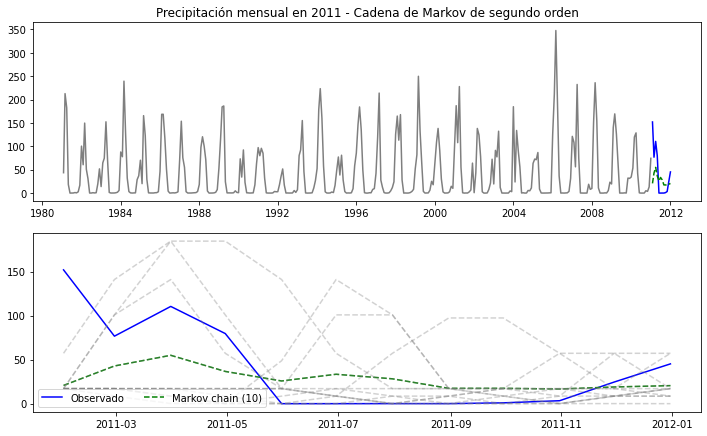

In [ ]:
# Visualización - pronóstico
fig, axes = plt.subplots(2,1, figsize = (10,6))
fig.tight_layout()

axes[0].set_title('Precipitación mensual en 2011 - Cadena de Markov de segundo orden')
axes[0].plot(df['pp'], 'C7')
axes[0].plot(df_pred, 'b-')
axes[0].plot(df_markov['mean'], 'g--')

axes[1].plot(df_pred, 'b-')

axes[1].plot(df_markov['mean'], 'g--')

for x in df_markov.columns:
  axes[1].plot(df_markov[x], color = 'C7', alpha = 0.35, linestyle = '--')


axes[1].legend(['Observado','Markov chain (10)'], loc = 3, ncol = 2)

Cada corrida del código muestra una gráfica diferente al escoger una vía aleatoria diferente, en general, no se ajusta :'v

In [ ]:
reco = list(cc_1['c'][1:])
reco_F = F.pp_transform(pp_pred=reco)
df_reco = pd.DataFrame(reco_F, index = df.index[1:], columns=['pp_reco'])

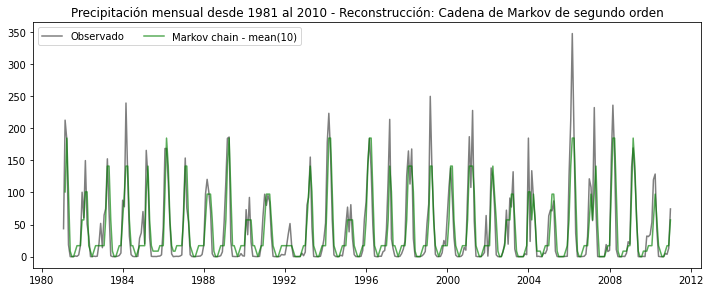

In [ ]:
# Visualización - Reconstrucción con Marcov Chain de 2do orden
fig, axes = plt.subplots(1,1, figsize = (10,4))
fig.tight_layout()

axes.set_title('Precipitación mensual desde 1981 al 2010 - Reconstrucción: Cadena de Markov de segundo orden')
axes.plot(df['pp'], 'C7')
axes.plot(df_reco['pp_reco'], 'g-', alpha = 0.65)
axes.legend(['Observado', 'Markov chain'], ncol = 2)

In [ ]:
### PROMEDIO DE 10 SALIDAS DE MARKOV CHAIN (FORZADO)
# ADVERTENCIA: es muy tardado y no garantiza buenos resultados
"""
F = MarkovChain(P, pp_dic)
last_month = str(cc_1['c'][-1:])[7:9]
df_markov = pd.DataFrame(index=df_pred.index)

d=100
while abs(d)>=50:
  for n in range(10):
    while df_markov.shape[1]<=10:
      try:
        pp_pred = F.generate_states(current_state= last_month, no=12) # estimación de 12 meses (2011)    #print(pp_pred)
        pp_t = F.pp_transform() #; print(f'{pp_t}.:4f')
        markov_pred = pd.DataFrame(pp_t, index = df_pred.index, columns=['pp'])
        df_markov = pd.concat([df_markov,markov_pred], ignore_index = True, axis = 1)
      except (ValueError):
        print('F')
        continue
  df_markov['mean'] = df_markov.apply(func='mean', axis = 1)
  d = df_pred['pp'][0]-df_markov['mean'][0]
  if abs(d)>=50: df_markov = pd.DataFrame(index=df_pred.index)
  else: None
df_markov
"""